# Online Recommendation System Project

#### I utilized data from the UCI Machine Learning Repository of an Online Retail Store. The data observed contains 541909 rows and 7 columns, InvoiceNo, StockCode, Description, Quantity, UnitPrice, CustomerID, and Country.

## Imported the needed packages

In [229]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

## Went to the directory where I want to work

In [2]:
#Changing working directory
os.chdir(r"C:\Users\dixon\Desktop\Data Science")
os.getcwd()

'C:\\Users\\dixon\\Desktop\\Data Science'

## Import data and set the index to datetime. Check to see if there are any missing values and what are the columns name.

In [3]:
#Importing data and setting the index to datetime
df=pd.read_csv('Online Retail.csv', parse_dates=True, index_col="InvoiceDate")

## Checked the data to see if there were any missing calues and to obtain the types of data. 

In [4]:
#Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Observed how the data looked to see if there are any patterns.

In [5]:
#Looking at the data set to observe visual trends
print(df)

                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
2010-12-01 08:26:00    536365     22752         SET 7 BABUSHKA NESTING BOXES   
2010-12-01 08:26:00    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER   
2010-12-01 08:28:00    536366     22633               HAND WARMER UNION JACK   
2010-12-01 08:28:00    536366     22632            HAND WARMER RED POLKA DOT   
2010-12-01 08:34:00    536367     84879        ASSORTED COLOUR BIRD ORNAMENT   
2010-12-01 08:34:00    536367     22745 

## Removed the Country column, this is not needed information. Stripped the letters from the StockCode column to make an integer Dropped the promotional items because they were given. We only care about items customers wanted to buy.

In [247]:
#dropping the Country column because it is not needed
df_dropped=df.drop(['Country'],axis=1)
df_pos_price = df_dropped.loc[lambda df_dropped: (df_dropped['UnitPrice'] > 0) & (df_dropped['Quantity'] > 0)]
df_pos_price.StockCode.apply(lambda x:  x.rstrip('ABCDEFGHIJKLMNOPQRSTUVWXyZ'))
print(df_pos_price)

                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
2010-12-01 08:26:00    536365     22752         SET 7 BABUSHKA NESTING BOXES   
2010-12-01 08:26:00    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER   
2010-12-01 08:28:00    536366     22633               HAND WARMER UNION JACK   
2010-12-01 08:28:00    536366     22632            HAND WARMER RED POLKA DOT   
2010-12-01 08:34:00    536367     84879        ASSORTED COLOUR BIRD ORNAMENT   
2010-12-01 08:34:00    536367     22745 

## Looking to see how many products were purchased by each customer.

In [217]:
#observe the data where we have all column data 
CustomerID = df_pos_price.groupby('CustomerID').count()
print(CustomerID)

            InvoiceNo  StockCode  Description  Quantity  UnitPrice
CustomerID                                                        
12346.0             1          1            1         1          1
12347.0           182        182          182       182        182
12348.0            31         31           31        31         31
12349.0            73         73           73        73         73
12350.0            17         17           17        17         17
12352.0            85         85           85        85         85
12353.0             4          4            4         4          4
12354.0            58         58           58        58         58
12355.0            13         13           13        13         13
12356.0            59         59           59        59         59
12357.0           131        131          131       131        131
12358.0            19         19           19        19         19
12359.0           248        248          248       248       

## We want to make sure the customers purchase frequently to get an accurate recommendation. If a customer was a single shopper, there could skew the results.

In [218]:
#customers less than 50 orders
df_clean=CustomerID.loc[lambda CustomerID: CustomerID['InvoiceNo'] > 50]
print(df_clean)

            InvoiceNo  StockCode  Description  Quantity  UnitPrice
CustomerID                                                        
12347.0           182        182          182       182        182
12349.0            73         73           73        73         73
12352.0            85         85           85        85         85
12354.0            58         58           58        58         58
12356.0            59         59           59        59         59
12357.0           131        131          131       131        131
12359.0           248        248          248       248        248
12360.0           129        129          129       129        129
12362.0           266        266          266       266        266
12364.0            85         85           85        85         85
12370.0           167        167          167       167        167
12371.0            63         63           63        63         63
12372.0            52         52           52        52       

## Created a DataFrame that indexed the StockCode and used CustomerID the Columns where we figured the values to be the Quantity shared between them. After, we normalized the data.

In [254]:
cluster1 = df_clean.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', aggfunc = np.sum).fillna(value=0)
cluster1_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster1)
print(cluster1_minmax)

CustomerID  12347.0  12349.0  12352.0  12354.0  12356.0  12357.0  12359.0  \
StockCode                                                                   
51              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
52              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
53              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
54              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
55              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
56              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
57              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
58              0.0      0.0      0.0     58.0      0.0      0.0      0.0   
59              0.0      0.0      0.0      0.0     59.0      0.0      0.0   
60              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
61              0.0      0.0      0.0      0.0      0.0      0.0      0.0   

C:\Users\dixon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Figured out the optimal k (number of clusters) for the DataFrame. 

In [245]:
Sum_of_squared = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster1_minmax)
    Sum_of_squared.append(km.inertia_)

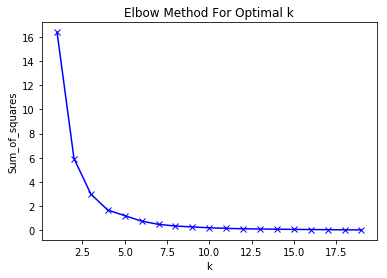

In [246]:
plt.plot(K, Sum_of_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

## Created a DataFrame that indexed the CustomerID and used StockCode the Columns where we figured the values to be the Quantity shared between them. After, we normalized the data.

In [249]:
cluster2 = df_clean.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc = np.sum).fillna(value=0)
cluster2_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster1_minmax)

[[0.01680349 0.01680349 0.01680349 0.01680349 0.01680349]
 [0.00282196 0.00282196 0.00282196 0.00282196 0.00282196]
 [0.00436121 0.00436121 0.00436121 0.00436121 0.00436121]
 ...
 [0.01475115 0.01475115 0.01475115 0.01475115 0.01475115]
 [0.09043099 0.09043099 0.09043099 0.09043099 0.09043099]
 [0.00243715 0.00243715 0.00243715 0.00243715 0.00243715]]


C:\Users\dixon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Figured out the optimal k (number of clusters) for the DataFrame. 

In [252]:
Sum_of_squared = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster2_minmax)
    Sum_of_squared.append(km.inertia_)

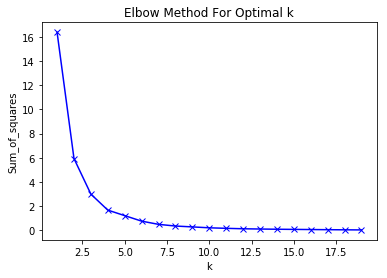

In [253]:
plt.plot(K, Sum_of_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

### From observations above, our optimal k=7. 